# Combine images

In [191]:
import warnings

import numpy as np

from astropy.io import fits
from astropy.wcs import WCS

from reproject import reproject_interp

import matplotlib.pyplot as plt

In [207]:
FITS_FILES = [ # FILENAME
    'SN2019muj_V01_NOT_ALFOSC_20191009.wcs.fits',
    'SN2019muj_r01_NOT_ALFOSC_20191009.wcs.fits',
]

NEW_FILENAME = '_SN2019muj_r01_NOT_ALFOSC.comb.wcs.fits'

## Load images

In [193]:
images = []
total_exptime = 0.0
exptime_keyword = 'EXPTIME'
for f in FITS_FILES:
    
    image = type('image', (object,), dict())
    with fits.open(f) as hdul:
        
        image.image = hdul[0].data #* w
        image.header = hdul[0].header
        
        try:
            total_exptime += image.header[exptime_keyword]
        except KeyError:
            print(f"Expsure time keyword {exptime_keyword} not found in header."
                "Change the key if needed. Else total exposure time will be wrong.")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            image.wcs = WCS(hdul[0].header)
    
    images.append(image)
reference_header = images[0].header
reference_header['N'] = len(images)

## Only pixel offset

In [211]:
newimage = type('image', (object,), dict(
    image = images[0].image.copy().astype(np.float64),
    header = images[0].header.copy(),
    wcs = images[0].wcs.copy()
))

for image in images[1:]:

    ra, dec = images[0].wcs.all_pix2world(0, 0, 0)
    
    dx, dy = list(map(int, map(np.round, image.wcs.all_world2pix(ra, dec, 0))))
    dh, dw = np.array(image.image.shape) - np.array(newimage.image.shape)

    s = [[
        (slice(None, dh if dh < 0 else None), slice(None, dw if dw < 0 else None)),
        (slice(None, None, -1 if dy < 0 else 1), slice(None, None, -1 if dx < 0 else 1)),
        (slice(None, -abs(dy) if dy else None), slice(None, -abs(dx) if dx else None))
    ],[
        (slice(None, -dh if -dh < 0 else None), slice(None, -dw if -dw < 0 else None)),
        (slice(None, None, -1 if dy < 0 else 1), slice(None, None, -1 if dx < 0 else 1)),
        (slice(abs(dy), None), slice(abs(dx), None))
    ]]

    newimage.image[s[0][0]][s[0][1]][s[0][2]] += image.image[s[1][0]][s[1][1]][s[1][2]]

newimage.image /= total_exptime

## Full WCS transformation

In [209]:
newimage = type('image', (object,), dict(
    image = images[0].image.copy().astype(np.float64),
    header = images[0].header.copy(),
    wcs = images[0].wcs.copy()
))

for image in images[1:]:

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        reproject, mask = reproject_interp((image.image, image.header), newimage.header)
    
    newimage.image += reproject
    reference

newimage.image /= total_exptime

## Show new image

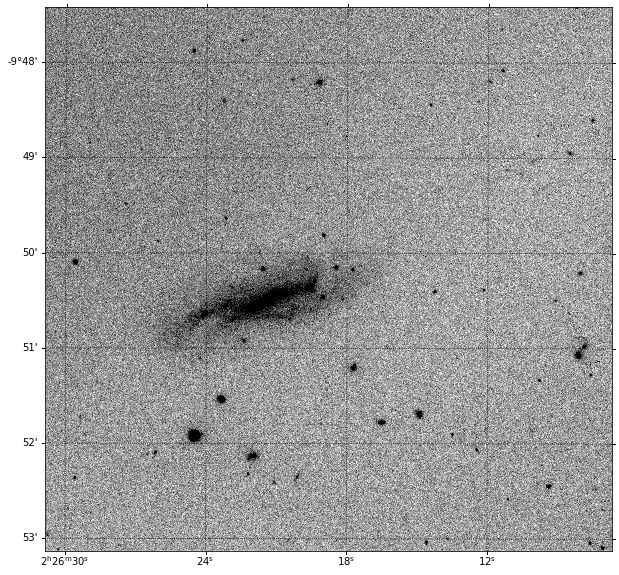

In [195]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=images[0].wcs)

clim = np.nanpercentile(newimage.image, (0.5, 99.5))
ax.imshow(newimage.image, cmap='gray_r', clim=clim, origin='lower')
ax.grid(ls='dotted', color='black')

In [197]:
data = newimage.image.astype(images[0].image.dtype)
reference_header.update(newimage.wcs.to_header())
# We normalized to 1 second exposure by dividing by the exposure time.
reference_header[exptime_keyword] = 1 


hdu = fits.PrimaryHDU([data], reference_header)
try: hdu.writeto(NEW_FILENAME)
except OSError as e: print(e)